In [1]:
# ================================================================
# 0. Imports
# ================================================================
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, roc_auc_score, mean_squared_error)
from lightgbm import LGBMClassifier, LGBMRegressor
import joblib
import shap
import matplotlib.pyplot as plt

In [2]:
# ================================================================
# 1. Data loading & basic cleanup (same as baseline 2.0)
# ================================================================
df = pd.read_excel("window_breakage_data.xlsx")
df = df.drop(columns=["YldFrctn"])
leak_cols = ["Yield", "YieldX", "PF Rowstate"]   # no Breakage Rate here
df = df.drop(columns=leak_cols)
df = df.dropna(subset=["Pass/Fail"])

df["PassFail_bin"] = df["Pass/Fail"].map({"Pass": 1, "Fail": 0})

X = df.drop(columns=["Pass/Fail", "PassFail_bin", "Breakage Rate"])
y_cls = df["PassFail_bin"]
y_reg = df["Breakage Rate"]

numeric_feats = X.select_dtypes(include=["float", "int"]).columns
categorical_feats = X.select_dtypes(include=["object", "category"]).columns

# ================================================================
# 2. Preprocessing (same as before; Unknown for missing cat)
# ================================================================
numeric_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])
categorical_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="constant", fill_value="Unknown")),
    ("encoder", OneHotEncoder(handle_unknown="ignore"))
])
preprocess = ColumnTransformer([
    ("num", numeric_transformer, numeric_feats),
    ("cat", categorical_transformer, categorical_feats)
])

In [3]:
# ================================================================
# 3. Train–test split
# ================================================================
X_train, X_test, y_train_cls, y_test_cls, y_train_reg, y_test_reg = train_test_split(
    X, y_cls, y_reg, test_size=0.2, random_state=42,
    shuffle=True, stratify=y_cls
)

preprocess.fit(X_train)
X_train_enc = preprocess.transform(X_train)
X_valid_enc = preprocess.transform(X_test)

# ================================================================
# 4. LightGBM – Classification
# ================================================================
lgbm_cls = LGBMClassifier(
    objective="binary",
    boosting_type="gbdt",
    n_estimators=1000,
    learning_rate=0.05,
    num_leaves=31,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=0.1,
    reg_lambda=0.1,
    random_state=42,
    class_weight="balanced"
)

cls_pipe = Pipeline([
    ("preprocess", preprocess),
    ("model", lgbm_cls)
])

# Early stopping
lgbm_cls.fit(
    X_train_enc, y_train_cls,
    eval_set=[(X_valid_enc, y_test_cls)],
    eval_metric="auc",
    callbacks=[lgb.early_stopping(stopping_rounds=50)]
)

y_pred_cls = cls_pipe.predict(X_test)
y_pred_prob = cls_pipe.predict_proba(X_test)[:, 1]

print("=== Classification Metrics (LightGBM) ===")
print("Accuracy :", accuracy_score(y_test_cls, y_pred_cls))
print("Precision:", precision_score(y_test_cls, y_pred_cls))
print("Recall   :", recall_score(y_test_cls, y_pred_cls))
print("F1       :", f1_score(y_test_cls, y_pred_cls))
print("ROC-AUC  :", roc_auc_score(y_test_cls, y_pred_prob))

joblib.dump(cls_pipe, "lgbm_classifier.pkl")

[LightGBM] [Info] Number of positive: 726, number of negative: 314
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000372 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2269
[LightGBM] [Info] Number of data points in the train set: 1040, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [W

['lgbm_classifier.pkl']

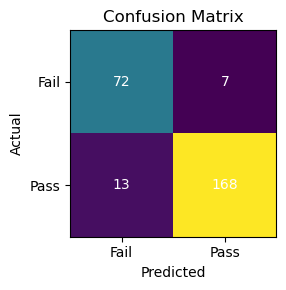

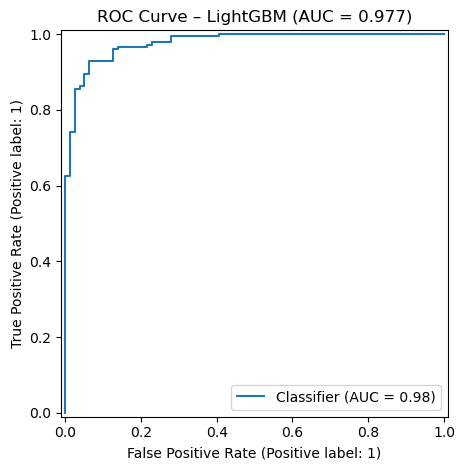

In [27]:
# -------------------------------------------------------------
# Confusion Matrix & ROC Curve  –  LightGBM Classification
# -------------------------------------------------------------
import matplotlib.pyplot as plt
from sklearn.metrics import RocCurveDisplay, confusion_matrix

# ❶ Confusion matrix
cm = confusion_matrix(y_test_cls, y_pred_cls, labels=[0, 1])  # 0=Fail, 1=Pass
fig, ax = plt.subplots(figsize=(4, 3))
im = ax.imshow(cm, interpolation="nearest")
ax.set_xticks([0, 1]); ax.set_yticks([0, 1])
ax.set_xticklabels(["Fail", "Pass"]); ax.set_yticklabels(["Fail", "Pass"])
ax.set_xlabel("Predicted"); ax.set_ylabel("Actual")
for i in range(2):
    for j in range(2):
        ax.text(j, i, cm[i, j], ha="center", va="center", color="white")
ax.set_title("Confusion Matrix")
plt.tight_layout()
plt.show()

# ❷ ROC curve
RocCurveDisplay.from_predictions(y_test_cls, y_pred_prob)
plt.title("ROC Curve – LightGBM (AUC = %.3f)" % roc_auc_score(y_test_cls, y_pred_prob))
plt.tight_layout()
plt.show()


In [4]:
# ================================================================
# 5. LightGBM – Regression
# ================================================================
# Optional: log1p transform target to reduce skew
y_train_reg_log = np.log1p(y_train_reg)
y_test_reg_log  = np.log1p(y_test_reg)

preprocess.fit(X_train)
X_train_enc = preprocess.transform(X_train)
X_valid_enc = preprocess.transform(X_test)

lgbm_reg = LGBMRegressor(
    objective="regression",
    boosting_type="gbdt",
    n_estimators=1000,
    learning_rate=0.05,
    num_leaves=31,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=0.1,
    reg_lambda=0.1,
    random_state=42
)

reg_pipe = Pipeline([
    ("preprocess", preprocess),
    ("model", lgbm_reg)
])

lgbm_reg.fit(
    X_train_enc, y_train_reg_log,
    eval_set=[(X_valid_enc, y_test_reg_log)],
    eval_metric="l2",
    callbacks=[lgb.early_stopping(stopping_rounds=50)]
)

y_pred_reg_log = lgbm_reg.predict(X_valid_enc, num_iteration=lgbm_reg.best_iteration_)
y_pred_reg = np.expm1(y_pred_reg_log)  # inverse log1p
rmse = mean_squared_error(y_test_reg, y_pred_reg, squared=False)
print("RMSE (LightGBM):", rmse)

joblib.dump((preprocess, lgbm_reg), "lgbm_regressor.pkl")

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000240 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2269
[LightGBM] [Info] Number of data points in the train set: 1040, number of used features: 22
[LightGBM] [Info] Start training from score 1.719740
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[317]	valid_0's l2: 0.143303
RMSE (LightGBM): 1.9143803477510242


/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


['lgbm_regressor.pkl']

In [25]:
# ================================================================
# 6. Cross-validation with early stopping
# ================================================================
from copy import deepcopy
from sklearn.metrics import (accuracy_score, f1_score, roc_auc_score,
                             precision_score, recall_score)
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.base import clone
import lightgbm as lgb
import numpy as np

# ---------- Helper dicts ----------
cls_scores = {"acc": [], "prec": [], "rec": [], "f1": [], "auc": []}
reg_scores = {"rmse": []}

# ---------- Stratified CV for classification ----------
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for fold, (tr_idx, va_idx) in enumerate(skf.split(X, y_cls), 1):
    X_tr, X_va = X.iloc[tr_idx], X.iloc[va_idx]
    y_tr, y_va = y_cls.iloc[tr_idx], y_cls.iloc[va_idx]

    # clone & fit preprocess
    prep_cv = deepcopy(preprocess)
    prep_cv.fit(X_tr)
    X_tr_enc = prep_cv.transform(X_tr)
    X_va_enc = prep_cv.transform(X_va)

    # clone model
    mdl_cv = clone(lgbm_cls)
    mdl_cv.fit(
        X_tr_enc, y_tr,
        eval_set=[(X_va_enc, y_va)],
        eval_metric="auc",
        callbacks=[lgb.early_stopping(50)]
    )

    y_pred = mdl_cv.predict(X_va_enc)
    y_prob = mdl_cv.predict_proba(X_va_enc)[:, 1]

    cls_scores["acc"].append(accuracy_score(y_va, y_pred))
    cls_scores["prec"].append(precision_score(y_va, y_pred))
    cls_scores["rec"].append(recall_score(y_va, y_pred))
    cls_scores["f1"].append(f1_score(y_va, y_pred))
    cls_scores["auc"].append(roc_auc_score(y_va, y_prob))

print("=== 5-fold CV (Classification) ===")
for k, v in cls_scores.items():
    print(f"{k.upper():<4}: {np.mean(v):.3f} ± {np.std(v):.3f}")

# ---------- K-fold CV for regression ----------
kf = KFold(n_splits=5, shuffle=True, random_state=42)

for fold, (tr_idx, va_idx) in enumerate(kf.split(X), 1):
    X_tr, X_va = X.iloc[tr_idx], X.iloc[va_idx]
    y_tr_raw, y_va_raw = y_reg.iloc[tr_idx], y_reg.iloc[va_idx]

    # log1p transform target
    y_tr = np.log1p(y_tr_raw)
    y_va = np.log1p(y_va_raw)

    # preprocess
    prep_cv = deepcopy(preprocess)
    prep_cv.fit(X_tr)
    X_tr_enc = prep_cv.transform(X_tr)
    X_va_enc = prep_cv.transform(X_va)

    # model
    mdl_cv = clone(lgbm_reg)
    mdl_cv.fit(
        X_tr_enc, y_tr,
        eval_set=[(X_va_enc, y_va)],
        eval_metric="l2",
        callbacks=[lgb.early_stopping(50)]
    )

    y_pred_log = mdl_cv.predict(X_va_enc)
    y_pred = np.expm1(y_pred_log)          # invert log1p
    rmse = mean_squared_error(y_va_raw, y_pred, squared=False)
    reg_scores["rmse"].append(rmse)

print("\n=== 5-fold CV (Regression) ===")
print(f"RMSE: {np.mean(reg_scores['rmse']):.3f} ± {np.std(reg_scores['rmse']):.3f}")


[LightGBM] [Info] Number of positive: 725, number of negative: 315
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000233 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2269
[LightGBM] [Info] Number of data points in the train set: 1040, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[L

/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Early stopping, best iteration is:
[272]	valid_0's l2: 0.141291
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000079 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2268
[LightGBM] [Info] Number of data points in the train set: 1040, number of used features: 22
[LightGBM] [Info] Start training from score 1.703927
Training until validation scores don't improve for 50 rounds


/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Early stopping, best iteration is:
[182]	valid_0's l2: 0.160938
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000135 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2267
[LightGBM] [Info] Number of data points in the train set: 1040, number of used features: 22
[LightGBM] [Info] Start training from score 1.729842
Training until validation scores don't improve for 50 rounds


/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Early stopping, best iteration is:
[151]	valid_0's l2: 0.13791
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000076 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2272
[LightGBM] [Info] Number of data points in the train set: 1040, number of used features: 22
[LightGBM] [Info] Start training from score 1.724672
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[133]	valid_0's l2: 0.161921

=== 5-fold CV (Regression) ===
RMSE: 2.216 ± 0.147


/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


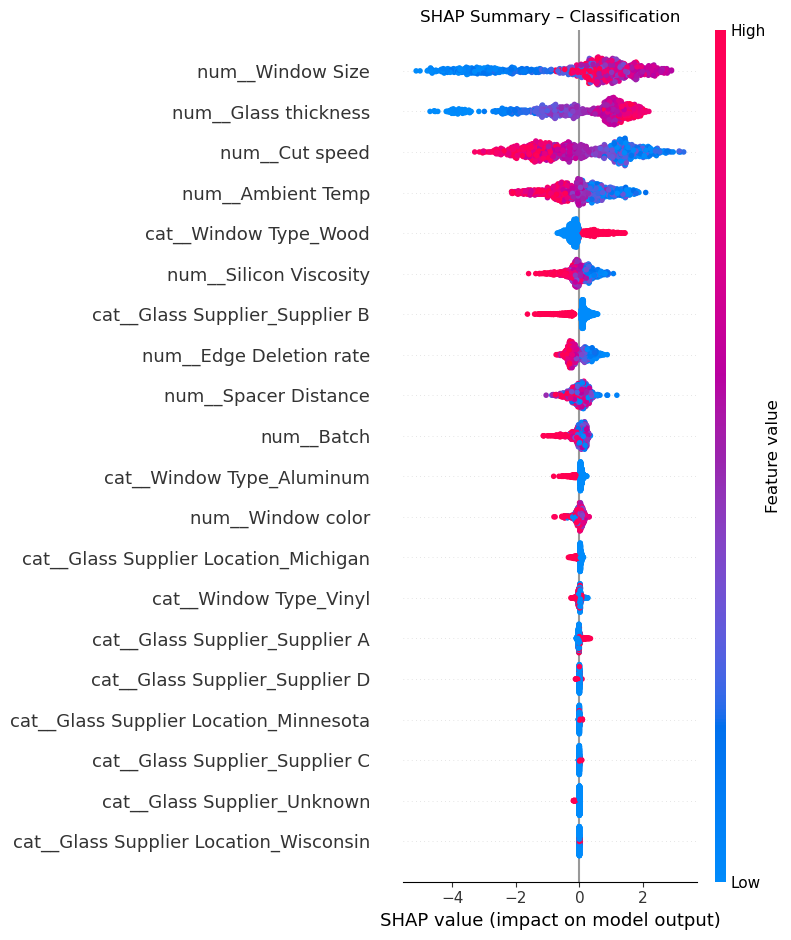

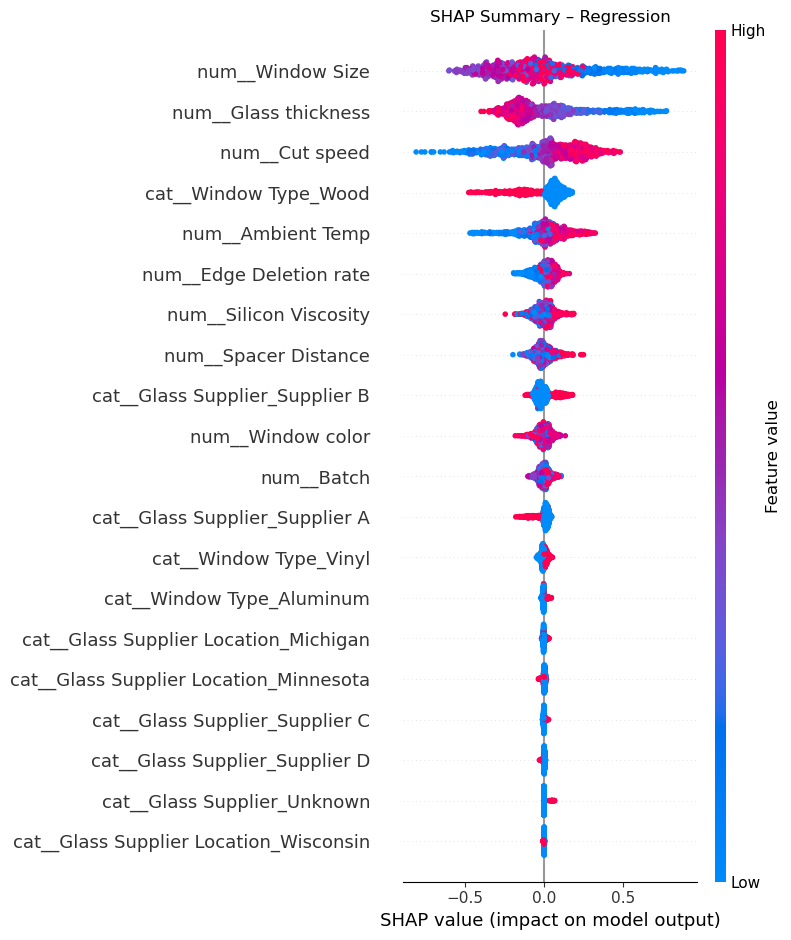

In [ ]:
# ================================================================
# 7. SHAP – Classification
# ================================================================
X_train_enc_cls = preprocess.transform(X_train)          # reuse fitted preprocess
explainer_cls = shap.Explainer(lgbm_cls)
shap_values_cls = explainer_cls(X_train_enc_cls)

shap.summary_plot(
    shap_values_cls, X_train_enc_cls,
    feature_names=preprocess.get_feature_names_out(),
    show=False
)
plt.title("SHAP Summary – Classification")
plt.tight_layout()
plt.show()

# ================================================================
# 8. SHAP – Regression
# ================================================================
X_train_enc_reg = X_train_enc                            # calculated
explainer_reg = shap.Explainer(lgbm_reg)
shap_values_reg = explainer_reg(X_train_enc_reg)

shap.summary_plot(
    shap_values_reg, X_train_enc_reg,
    feature_names=preprocess.get_feature_names_out(),
    show=False
)
plt.title("SHAP Summary – Regression")
plt.tight_layout()
plt.show()

# Dependence plot for top feature
# top_feat_idx = np.argsort(np.abs(shap_values_reg.values).mean(0))[-1]
# shap.dependence_plot(
#     top_feat_idx, shap_values_reg, X_train_enc_reg,
#     feature_names=preprocess.get_feature_names_out()
# )
